In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

In [2]:
import json
from collections import defaultdict
from pathlib import Path
from typing import Dict

In [3]:
def compute_normalized_scores(jsonl_path: str | Path) -> Dict[str, float]:
    """
    Read `annotations.jsonl` and return {model_name: avg_score}.
    
    Scoring per battle
    ------------------
    winner  : +1.0  
    loser   : +0.0  
    each tie: +0.5  
    
    Normalization
    -------------
    avg_score = total_points / num_battles   (so 3 wins + 1 loss → 3/4 = 0.75)
    """
    jsonl_path = Path(jsonl_path).expanduser()
    if not jsonl_path.exists():
        raise FileNotFoundError(jsonl_path)

    # running tallies
    points  = defaultdict(float)   # total points earned
    battles = defaultdict(int)     # how many times the model appeared

    count = 0
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                rec = json.loads(line)
                m1, m2 = rec["model1"], rec["model2"]
                pref   = rec["preference"]           # "model1" | "model2" | "tie"
            except (KeyError, json.JSONDecodeError):
                continue                             # skip malformed lines

            # each model fought once in this record
            battles[m1] += 1
            battles[m2] += 1

            if pref == "model1":
                points[m1] += 1.0
            elif pref == "model2":
                points[m2] += 1.0
            elif pref == "tie":
                points[m1] += 0.5
                points[m2] += 0.5
            # unknown preference token → ignore it quietly

            count += 1
    print(f"Counted {count} records in {jsonl_path}")
    # normalize
    normalized = {
        model: (points[model] / battles[model]) * 100 if battles[model] else 0.0
        for model in battles
    }
    return normalized

In [4]:
model_judge_scores = {
    "gpt4o-audio": 46.95,
    "gpt4o-audio+asr+tts": 29.88,
    "gemini2-flash-exp": 24.39,
    "gemini2-flash-exp+asr+tts": 23.78,
    # ------------------- #
    "typhoon2-audio": 20.12,
    "llama-omni": 13.41,
    "moshi": 4.27,
    # ------------------- #
    "gpt4o-text+tts": 26.83,
    "gemini2-flash-text+tts": 34.15,
    "diva+tts": 29.88,
    "typhoon2-audio+tts": 18.90,
    "qwen2-audio+tts": 18.29,
    "asr+llama3+tts": 34.15,
}

Counted 508 records in annotations-508.jsonl
Spearman ρ = 0.766   (p = 0.00227)


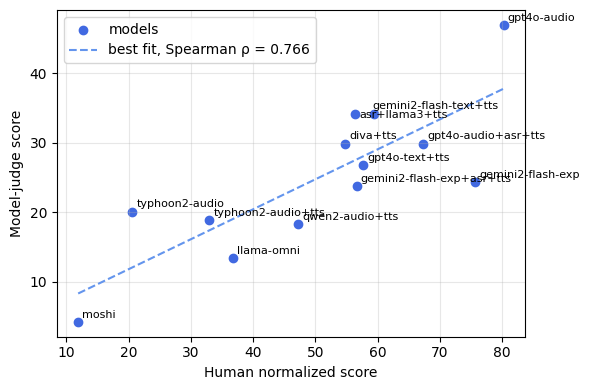

In [8]:
human_scores = compute_normalized_scores("annotations-508.jsonl")

# --- overlap & vectors -------------------------------------------------------
common = sorted(set(model_judge_scores) & set(human_scores))

human = np.array([human_scores[m]        for m in common])
judge = np.array([model_judge_scores[m]  for m in common])

# --- stats -------------------------------------------------------------------
rho, p = spearmanr(human, judge)
print(f"Spearman ρ = {rho:.3f}   (p = {p:.3g})")

# --- best-fit (y = ax + b) ---------------------------------------------------
a, b = np.polyfit(human, judge, 1)          # slope, intercept
x_line = np.linspace(human.min(), human.max(), 100)
y_line = a * x_line + b

# --- plot --------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(human, judge, label="models", color="royalblue")


plt.plot(x_line, y_line, '--', color="cornflowerblue", label=f"best fit, Spearman ρ = {rho:.3f}")

for m, hx, jx in zip(common, human, judge):
    if m == "asr+llama3+tts":
        plt.annotate(m, (hx, jx-1.2), fontsize=8, xytext=(3, 3),
            textcoords="offset points")   
    elif m == "gemini2-flash-text+tts":
        plt.annotate(m, (hx-1, jx+0.1), fontsize=8, xytext=(3, 3),
            textcoords="offset points")   
    else:
        plt.annotate(m, (hx, jx), fontsize=8, xytext=(3, 3),
                    textcoords="offset points")


plt.xlabel("Human normalized score")
plt.ylabel("Model-judge score")
# plt.title(f"Human vs Model-Judge  (ρ = {rho:.3f})")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("human_vs_model-judge.pdf", bbox_inches="tight")
plt.show()

In [7]:
# # Only computing correlation among mid-tier systems?

# human_scores = compute_normalized_scores("annotations-508.jsonl")

# # --- overlap & vectors -------------------------------------------------------
# common = sorted(set(model_judge_scores) & set(human_scores))
# nono = ['moshi', 'typhoon2-audio', 'typhoon2-audio+tts', 'llama-omni', 'qwen2-audio+tts']
# common = [m for m in common if m not in nono]
# human = np.array([human_scores[m]        for m in common])
# judge = np.array([model_judge_scores[m]  for m in common])

# # --- stats -------------------------------------------------------------------
# rho, p = spearmanr(human, judge)
# print(f"Spearman ρ = {rho:.3f}   (p = {p:.3g})")

# # --- best-fit (y = ax + b) ---------------------------------------------------
# a, b = np.polyfit(human, judge, 1)          # slope, intercept
# x_line = np.linspace(human.min(), human.max(), 100)
# y_line = a * x_line + b

# # --- plot --------------------------------------------------------------------
# plt.figure(figsize=(6, 4))
# plt.scatter(human, judge, label="models", color="royalblue")


# plt.plot(x_line, y_line, '--', color="cornflowerblue", label=f"best fit, Spearman ρ = {rho:.3f}")

# for m, hx, jx in zip(common, human, judge):
#     if m == "asr+llama3+tts":
#         plt.annotate(m, (hx, jx-1.2), fontsize=8, xytext=(3, 3),
#             textcoords="offset points")   
#     elif m == "gemini2-flash-text+tts":
#         plt.annotate(m, (hx-1, jx+0.1), fontsize=8, xytext=(3, 3),
#             textcoords="offset points")   
#     else:
#         plt.annotate(m, (hx, jx), fontsize=8, xytext=(3, 3),
#                     textcoords="offset points")


# plt.xlabel("Human normalized score")
# plt.ylabel("Model-judge score")
# # plt.title(f"Human vs Model-Judge  (ρ = {rho:.3f})")
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()
# # plt.savefig("human_vs_model-judge.pdf", bbox_inches="tight")
# plt.show()